In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import uproot as ur
import awkward as ak
import time
from multiprocessing import Process, Queue, Manager, set_start_method
# from multiprocess import Process, Queue, Manager, set_start_method
import compress_pickle as pickle
from scipy.stats import circmean
import matplotlib.ticker as ticker
from scipy.interpolate import make_interp_spline
import random

import sys
sys.path.insert(0, './functions')
from binning_utils import *


Using variable strings ['E', 'X', 'Y', 'Z'] from binning_utils.py



In [2]:
results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/set5_layers"
results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/five_set_layers"
results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/fixed_5front_1back"
results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/fixed_1front_5back"
#results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/4_segment_2rand"
#results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/FIXED_equidistant"
#results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/FIXED_2front_1back"
#results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/3_segment_1rand"
#results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/3_segment_1rand_redo"
#results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/3_segment_1rand_wXY"
#results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/3_segment_1rand_wXY_HighStat"
#results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/3_segment_1rand_HighStat"
#results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/3_segment_1rand_HighStatredo"
#results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/17_deg_1rand"
results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/17_deg_2rand"
#results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/17_deg_2rand_HighStat"
#results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/17_deg_2rand_10x" 
#results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/17_deg_1rand_2fixed_10x"
results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/17_deg_2rand_2fixed_10x_REDO"
#results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/17_deg_1rand_2fixed_10x_REDO"
#resutls_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/17_deg_2rand_400files"
results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/17_deg_2rand_400files_5Iter" # ----------------- This one
results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/17_deg_2rand_400files_FixedInference"
#results_dir = "/pscratch/sd/f/fernando/regressiononly/preprocessed/17_deg_2rand_XY_400Iter5"
already_processed = True

In [3]:
loss = np.load(f"{results_dir}/loss_standalone.npy")
preds = np.load(f"{results_dir}/predictions_standalone.npy")
targets = np.load(f"{results_dir}/targets_standalone.npy")
inputs = np.load(f'{results_dir}/inputs_standalone.npy',allow_pickle=True)

2023-08-03 11:57:55.791319: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 11:57:57.655611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-03 11:58:00.754652: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
if not already_processed:
    print(len(preds))
    globals = inputs[4::7]

    first_z_layer = []
    second_z_layer = []
    for batch in globals:
        for layers in batch: #list of 7 globals
            first_z_layer.append(float(layers[2]))
            second_z_layer.append(float(layers[3]))

    print(len(first_z_layer))

    first_z_layer = np.asarray(first_z_layer)
    second_z_layer = np.asarray(second_z_layer)

    z_means = pickle.load(open(f"{results_dir}/test/means.p",'rb'), compression='gzip')
    z_stdvs = pickle.load(open(f"{results_dir}/test//stdvs.p",'rb'), compression='gzip')

    unormed_first_z_layer = np.round(first_z_layer*z_stdvs[".position.z"] + z_means[".position.z"],2)
    unormed_second_z_layer = np.round(second_z_layer*z_stdvs[".position.z"] + z_means[".position.z"],2)

    MSE = ((preds - targets)**2)

    np.save(f"{results_dir}/first_z_layer.npy",unormed_first_z_layer)
    np.save(f"{results_dir}/second_z_layer.npy",unormed_second_z_layer)
    np.save(f"{results_dir}/MSE.npy",MSE)

In [5]:
unormed_first_z_layer = np.load(f"{results_dir}/first_z_layer.npy")
unormed_second_z_layer = np.load(f"{results_dir}/second_z_layer.npy")
MSE = np.load(f"{results_dir}/MSE.npy")

z_means = pickle.load(open(f"{results_dir}/test/means.p",'rb'), compression='gzip')
z_stdvs = pickle.load(open(f"{results_dir}/test//stdvs.p",'rb'), compression='gzip')

(array([ 299932.,  899796., 1499660., 2099524., 2699388., 3299252.,
        3899116., 4498980., 5098844., 8698028.]),
 array([3926.8, 4043.8, 4160.8, 4277.8, 4394.8, 4511.8, 4628.8, 4745.8,
        4862.8, 4979.8, 5096.8]),
 <BarContainer object of 10 artists>)

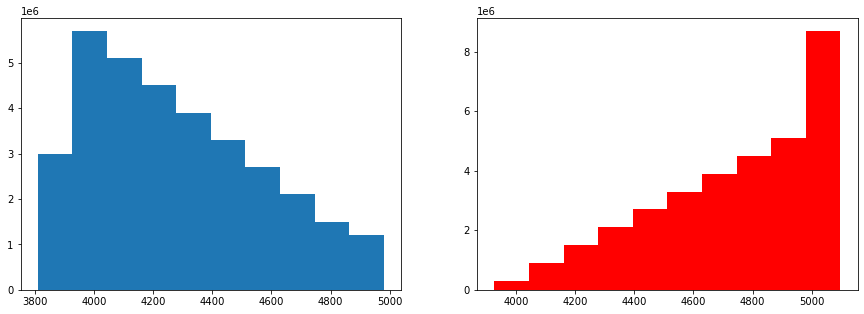

In [6]:
fig,axs = plt.subplots(nrows = 1,ncols = 2,figsize=(15,5))
axs[0].hist(unormed_first_z_layer)
axs[1].hist(unormed_second_z_layer,color="red")

In [7]:
print(len(unormed_first_z_layer))

32992520


In [8]:
means = []
for layer in np.unique(unormed_first_z_layer):
    means.append(np.mean(MSE[unormed_first_z_layer==layer]))
    
means = np.asarray(means)


means2 = []
for layer in np.unique(unormed_second_z_layer):
    means2.append(np.mean(MSE[unormed_second_z_layer==layer]))
    
means2 = np.asarray(means2)

In [9]:
print((np.unique(unormed_first_z_layer)))

[3809.8 3926.8 4043.8 4160.8 4277.8 4394.8 4511.8 4628.8 4745.8 4862.8
 4979.8]


Text(0.5, 1.0, 'Loading Input Test Graphs')

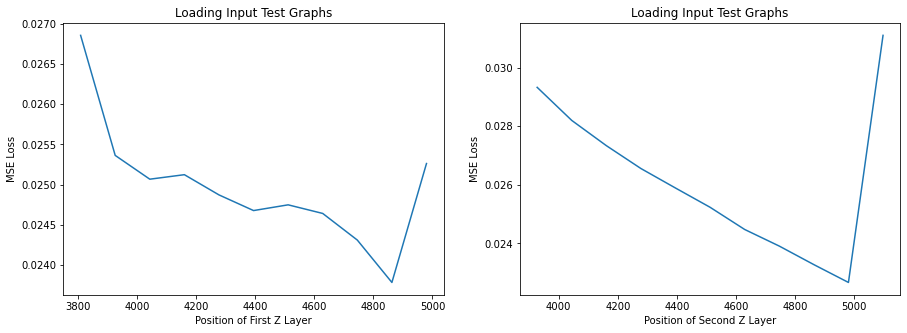

In [10]:

fig,axs = plt.subplots(nrows = 1,ncols = 2,figsize=(15,5))
axs[0].plot(np.unique(unormed_first_z_layer),means)
axs[0].set_ylabel("MSE Loss")
axs[0].set_xlabel("Position of First Z Layer")
axs[0].set_title("Loading Input Test Graphs")

axs[1].plot(np.unique(unormed_second_z_layer),means2)
axs[1].set_ylabel("MSE Loss")
axs[1].set_xlabel("Position of Second Z Layer")
axs[1].set_title("Loading Input Test Graphs")
#.ylim(0,0.06)

In [11]:
energy_resolution = []
predE = 10**(preds*z_stdvs["genP"] + z_means["genP"])
genP = 10**(targets*z_stdvs["genP"] + z_means["genP"])
energy_scale = predE/genP

for layer in np.unique(unormed_first_z_layer):
    energy_resolution.append(np.std(energy_scale[unormed_first_z_layer==layer]))

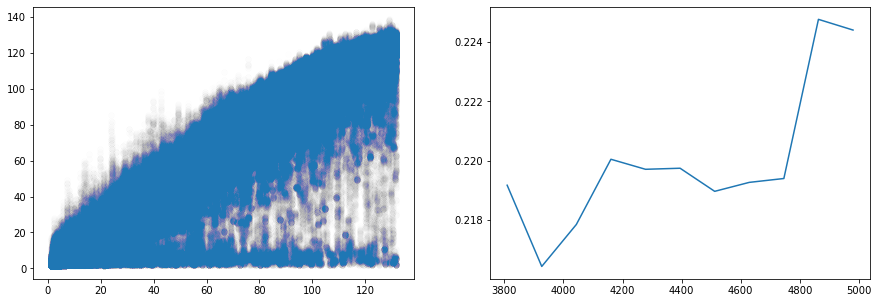

In [12]:
fig,axs = plt.subplots(nrows = 1,ncols = 2,figsize=(15,5))
axs[0].scatter(genP,predE,alpha=0.005)
axs[1].plot(np.unique(unormed_first_z_layer),energy_resolution)
#axs[1].set_ylim(0,10)

In [13]:
test_MSE = ((predE - genP)**2)
test_mean = []

for layer in np.unique(unormed_first_z_layer):
    test_mean.append(np.mean(test_MSE[unormed_first_z_layer==layer]))

Text(0.5, 1.0, 'Loading Input Test Graphs')

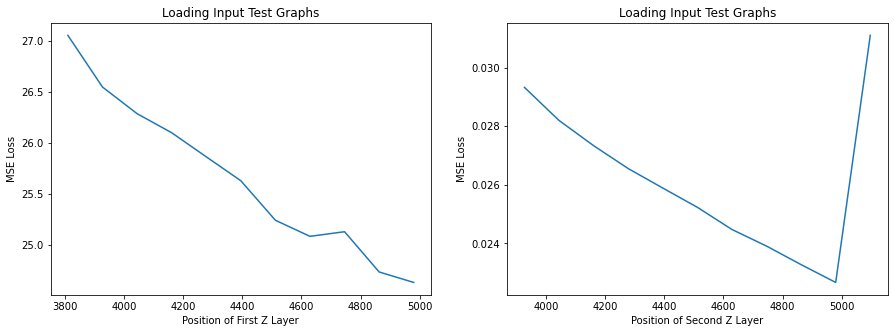

In [14]:
fig,axs = plt.subplots(nrows = 1,ncols = 2,figsize=(15,5))
axs[0].plot(np.unique(unormed_first_z_layer),test_mean)
axs[0].set_ylabel("MSE Loss")
axs[0].set_xlabel("Position of First Z Layer")
axs[0].set_title("Loading Input Test Graphs")

axs[1].plot(np.unique(unormed_second_z_layer),means2)
axs[1].set_ylabel("MSE Loss")
axs[1].set_xlabel("Position of Second Z Layer")
axs[1].set_title("Loading Input Test Graphs")
#.ylim(0,0.06)

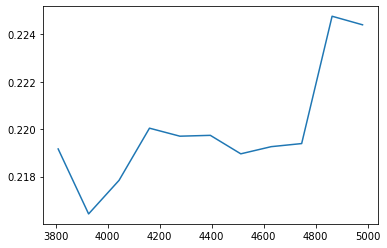

In [15]:
plt.plot(np.unique(unormed_first_z_layer),energy_resolution)
#plt.ylim(0,10)

In [16]:
differences = np.round(unormed_second_z_layer-unormed_first_z_layer,2)
meansD = []

for D in np.unique(differences):
    #print(D)
    meansD.append(np.mean(MSE[differences==D]))
    
meansD = np.asarray(meansD)

[0.02540344 0.02521485 0.0250851  0.0249186  0.02477856 0.02463788
 0.02465313 0.02489056 0.02557969 0.02837452]


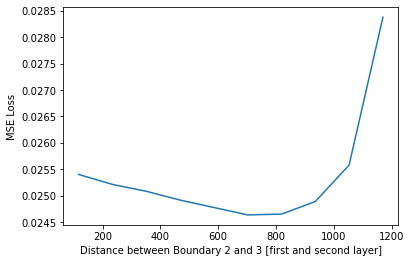

In [17]:
plt.plot(np.unique(np.round(differences,2)),meansD)
plt.ylabel("MSE Loss")
plt.xlabel("Distance between Boundary 2 and 3 [first and second layer]")
print(meansD)

Text(0.5, 1.0, 'E < 20.0')

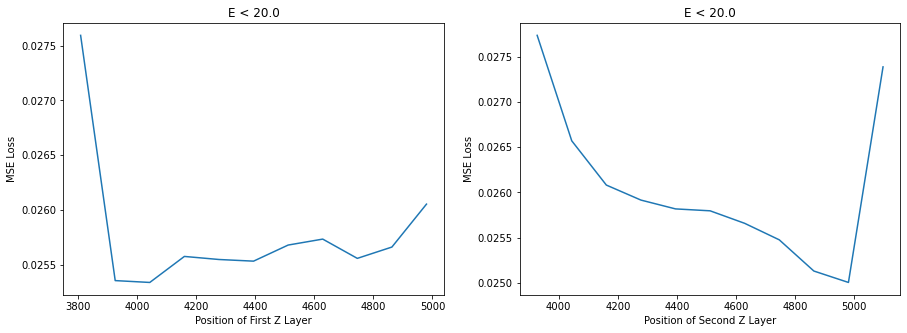

In [18]:
means = []
min_E = 20.0
emask = genP < min_E
#emask = genP > 80
nskip = 1


for layer in np.unique(unormed_first_z_layer):
    mask = np.logical_and(unormed_first_z_layer==layer ,emask)
    means.append(np.mean(MSE[mask]))
    
means = np.asarray(means)


means2 = []
for layer in np.unique(unormed_second_z_layer):
    mask2 = np.logical_and(unormed_second_z_layer==layer ,emask)
    means2.append(np.mean(MSE[mask2]))
    
means2 = np.asarray(means2)


#avg_layer1 = np.average(np.unique(unormed_first_z_layer).reshape(-1, nskip), axis=1)

#avg_mse1 = np.average(means.reshape(-1, nskip), axis=1)

fig,axs = plt.subplots(nrows = 1,ncols = 2,figsize=(15,5))
axs[0].plot(np.unique(unormed_first_z_layer)[::nskip],means[::nskip])
#axs[0].plot(avg_layer1,avg_mse1)
axs[0].set_ylabel("MSE Loss")
axs[0].set_xlabel("Position of First Z Layer")
axs[0].set_title(f"E < {min_E}")

axs[1].plot(np.unique(unormed_second_z_layer)[::nskip],means2[::nskip])
axs[1].set_ylabel("MSE Loss")
axs[1].set_xlabel("Position of Second Z Layer")
axs[1].set_title(f"E < {min_E}")
#.ylim(0,0.06)

[0.02575852]


ValueError: The number of derivatives at boundaries does not match: expected 3, got 0+0

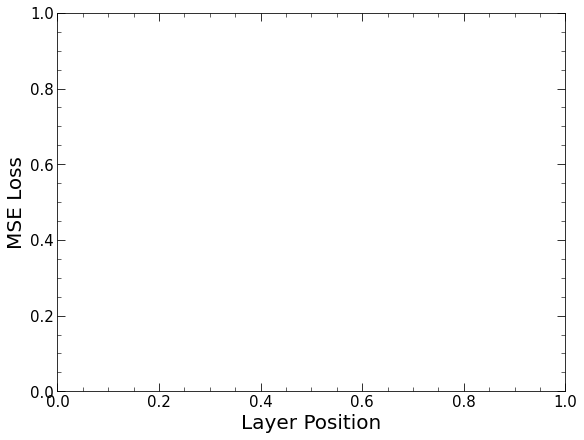

In [19]:
n_avg = 10
n_start = 0
n_end = 1
avg_means = np.mean(means[n_start:-n_end].reshape(-1, n_avg), axis=1)
avg_l1 = np.mean(np.unique(unormed_first_z_layer)[n_start:-n_end].reshape(-1,n_avg), axis=1)

avg_means2 = np.mean(means2[n_start:-n_end].reshape(-1, n_avg), axis=1)
avg_l2 = np.mean(np.unique(unormed_second_z_layer)[n_start:-n_end].reshape(-1,n_avg), axis=1)




print(avg_means)
fig, ax0 = plt.subplots(figsize=(8, 6),layout='constrained')

    
#Calculations
    
#ax0.plot(bin_centers,resolution_fit,label=label,marker='.',markersize=10)
    
ax0.tick_params(axis='both',which="major",direction='in',top=True,right=True,labelsize=15,length=8)
ax0.tick_params(axis='both',which="minor",direction='in',top=True,right=True,labelsize=15,length=4)
ax0.set_ylabel("MSE Loss",fontsize=20)
ax0.set_xlabel("Layer Position",fontsize=20)
    
ax0.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))
ax0.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))



#ax0.legend(fontsize=15)
#ax0.set_xlim(xmin,xmax)
means_spline = make_interp_spline(avg_l1, avg_means)
x = np.linspace(np.min(avg_l1),np.max(avg_l1),100)
y = means_spline(x)
#ax0.plot(x, y)
ax0.plot(avg_l1, avg_means,label="Layer 1")
means_spline = make_interp_spline(avg_l2, avg_means2)
x = np.linspace(np.min(avg_l2),np.max(avg_l2),100)
y = means_spline(x)
#ax0.plot(x, y)
ax0.plot(avg_l2, avg_means2,label="Layer 2")
ax0.legend(fontsize=20)
plt.title("E < 10.0 GeV")

In [ ]:
means = []
min_E = 11.0
max_E = 0.
#emask = genP < min_E
emask = genP > max_E
nskip = 1
for layer in np.unique(unormed_first_z_layer):
    mask = np.logical_and(unormed_first_z_layer==layer ,emask)
    means.append(np.mean(MSE[mask]))
    
means = np.asarray(means)


means2 = []
for layer in np.unique(unormed_second_z_layer):
    means2.append(np.mean(MSE[unormed_second_z_layer==layer]))
    
means2 = np.asarray(means2)


fig,axs = plt.subplots(nrows = 1,ncols = 2,figsize=(15,5))
axs[0].plot(np.unique(unormed_first_z_layer)[::nskip],means[::nskip])
axs[0].set_ylabel("MSE Loss")
axs[0].set_xlabel("Position of First Z Layer")
axs[0].set_title(f"E > {max_E}")

axs[1].plot(np.unique(unormed_second_z_layer)[::nskip],means2[::nskip])
axs[1].set_ylabel("MSE Loss")
axs[1].set_xlabel("Position of Second Z Layer")
axs[1].set_title(f"E > {max_E}")
#.ylim(0,0.06)

In [ ]:
n_avg = 12
n_start = 1
n_end = 2

avg_means = np.mean(means[n_start:-n_end].reshape(-1, n_avg), axis=1)
avg_l1 = np.mean(np.unique(unormed_first_z_layer)[n_start:-n_end].reshape(-1,n_avg), axis=1)

avg_means2 = np.mean(means2[n_start:-n_end].reshape(-1, n_avg), axis=1)
avg_l2 = np.mean(np.unique(unormed_second_z_layer)[n_start:-n_end].reshape(-1,n_avg), axis=1)


print(avg_means)
fig, ax0 = plt.subplots(figsize=(8, 6),layout='constrained')

plt.plot(avg_l1, avg_means,label="Layer 1")
plt.plot(avg_l2, avg_means2,label="Layer 2")

ax0.tick_params(axis='both',which="major",direction='in',top=True,right=True,labelsize=15,length=8)
ax0.tick_params(axis='both',which="minor",direction='in',top=True,right=True,labelsize=15,length=4)
ax0.set_ylabel("MSE Loss",fontsize=20)
ax0.set_xlabel("Layer Position",fontsize=20)
    
ax0.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))
ax0.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
ax0.set_title(f"E > {max_E} GeV")
ax0.legend(fontsize=20)

In [ ]:
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [ ]:
max_E = 10.0
emask = genP < max_E

res1 = []
for layer in np.unique(unormed_first_z_layer):
    mask1 = np.logical_and(unormed_first_z_layer==layer ,emask)
    res1.append(np.std(energy_scale[mask1]))
    
res2 = []
for layer in np.unique(unormed_second_z_layer):
    mask2 = np.logical_and(unormed_second_z_layer==layer ,emask)
    res2.append(np.std(energy_scale[mask2]))

res1 = np.asarray(res1)
res2 = np.asarray(res2)

n_avg = 10
n_start = 0
n_end = 1
avg_means = np.mean(res1[n_start:-n_end].reshape(-1, n_avg), axis=1)
avg_l1 = np.mean(np.unique(unormed_first_z_layer)[n_start:-n_end].reshape(-1,n_avg), axis=1)

avg_means2 = np.mean(res2[n_start:-n_end].reshape(-1, n_avg), axis=1)
avg_l2 = np.mean(np.unique(unormed_second_z_layer)[n_start:-n_end].reshape(-1,n_avg), axis=1)




print(avg_means)
fig, ax0 = plt.subplots(figsize=(8, 6),layout='constrained')

    
#Calculations
    
#ax0.plot(bin_centers,resolution_fit,label=label,marker='.',markersize=10)
    
ax0.tick_params(axis='both',which="major",direction='in',top=True,right=True,labelsize=15,length=8)
ax0.tick_params(axis='both',which="minor",direction='in',top=True,right=True,labelsize=15,length=4)
ax0.set_ylabel("Energy Resolution",fontsize=20)
ax0.set_xlabel("Layer Position",fontsize=20)
    
ax0.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))
ax0.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))



#ax0.legend(fontsize=15)
#ax0.set_xlim(xmin,xmax)
means_spline = make_interp_spline(avg_l1, avg_means)
x = np.linspace(np.min(avg_l1),np.max(avg_l1),100)
y = means_spline(x)
#ax0.plot(x, y)
ax0.plot(avg_l1, avg_means,label="Layer 1")
means_spline = make_interp_spline(avg_l2, avg_means2)
x = np.linspace(np.min(avg_l2),np.max(avg_l2),100)
y = means_spline(x)
#ax0.plot(x, y)
ax0.plot(avg_l2, avg_means2,label="Layer 2")
ax0.legend(fontsize=20)
plt.title(f"E < {max_E} GeV",fontsize=25)

In [ ]:
min_E = 50.0
emask = genP > min_E

res1 = []
for layer in np.unique(unormed_first_z_layer):
    mask1 = np.logical_and(unormed_first_z_layer==layer ,emask)
    res1.append(np.std(energy_scale[mask1]))
    
res2 = []
for layer in np.unique(unormed_second_z_layer):
    mask2 = np.logical_and(unormed_second_z_layer==layer ,emask)
    res2.append(np.std(energy_scale[mask2]))

res1 = np.asarray(res1)
res2 = np.asarray(res2)

n_avg = 10
n_start = 0
n_end = 1
avg_means = np.mean(res1[n_start:-n_end].reshape(-1, n_avg), axis=1)
avg_l1 = np.mean(np.unique(unormed_first_z_layer)[n_start:-n_end].reshape(-1,n_avg), axis=1)

avg_means2 = np.mean(res2[n_start:-n_end].reshape(-1, n_avg), axis=1)
avg_l2 = np.mean(np.unique(unormed_second_z_layer)[n_start:-n_end].reshape(-1,n_avg), axis=1)




print(avg_means)
fig, ax0 = plt.subplots(figsize=(8, 6),layout='constrained')

    
#Calculations
    
#ax0.plot(bin_centers,resolution_fit,label=label,marker='.',markersize=10)
    
ax0.tick_params(axis='both',which="major",direction='in',top=True,right=True,labelsize=15,length=8)
ax0.tick_params(axis='both',which="minor",direction='in',top=True,right=True,labelsize=15,length=4)
ax0.set_ylabel("Energy Resolution",fontsize=20)
ax0.set_xlabel("Layer Position",fontsize=20)
    
ax0.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))
ax0.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))



#ax0.legend(fontsize=15)
#ax0.set_xlim(xmin,xmax)
means_spline = make_interp_spline(avg_l1, avg_means)
x = np.linspace(np.min(avg_l1),np.max(avg_l1),100)
y = means_spline(x)
#ax0.plot(x, y)
ax0.plot(avg_l1, avg_means,label="Layer 1")
means_spline = make_interp_spline(avg_l2, avg_means2)
x = np.linspace(np.min(avg_l2),np.max(avg_l2),100)
y = means_spline(x)
#ax0.plot(x, y)
ax0.plot(avg_l2, avg_means2,label="Layer 2")
ax0.legend(fontsize=20)
plt.title(f"E > {min_E} GeV",fontsize=25)